# Finding the U_Shape

## 1. Import libraries and data

In [1]:
## Libraries 
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

In [2]:
## Data
data = pd.read_excel("./BDD_Projet_INSA_V2.xlsx")
### Data cleaning 
data["transfusion CG"][np.where(data["transfusion CG"] > 0)[0]] = 1
data.dropna(inplace=True)
data.set_index(np.arange(len(data)))
data.head()
len(data)

445

## 2. Exploration 

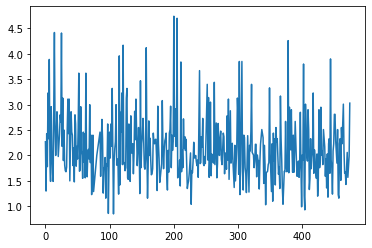

In [3]:
plt.plot(data["Fibri2"])

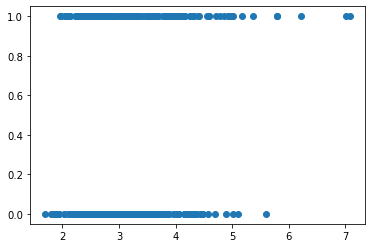

In [4]:
plt.scatter(data["fibrinogene"], data["transfusion CG"])

In [5]:
data.describe()

,transfusion CG,fibrinogene,Fibri2
count,445.000000,445.000000,445.000000
mean,0.368539,3.184472,2.141146
std,0.482952,0.778879,0.634767
min,0.000000,1.700000,0.850000
25%,0.000000,2.670000,1.740000
50%,0.000000,3.070000,2.010000
75%,1.000000,3.620000,2.430000
max,1.000000,7.080000,4.740000


In [6]:
data.quantile(0.25)[1]
data.quantile(0.50)[1]
data.quantile(0.75)[1]
data.min()[1]
data.max()[1]

7.08

## 3. Regression logistique sur les données directement

In [7]:
## calcul logit P
import statsmodels.api as sm

x = data["Fibri2"]  #data["fibrinogene"]
y = data["transfusion CG"]
x_stat = sm.add_constant(x)

model = sm.Logit(y, x_stat)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.658174
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         transfusion CG   No. Observations:                  445
Model:                          Logit   Df Residuals:                      443
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:               1.959e-10
Time:                        16:23:00   Log-Likelihood:                -292.89
converged:                       True   LL-Null:                       -292.89
Covariance Type:            nonrobust   LLR p-value:                    0.9997
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5386      0.346     -1.556      0.120      -1.217       0.140
Fibri2      4.912e-05      0.155      0.000      1.000      -0.304       0.304
==============================================================================
"""

In [8]:
alpha = -1.8400
beta = 0.4042
logitP = alpha + beta*x

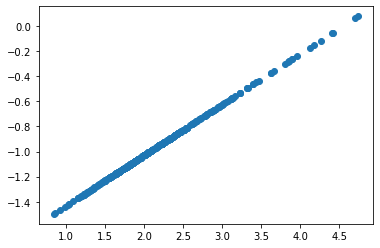

In [9]:
#plt.scatter(data["fibrinogene"], logit(prob(data[np.where(data["transfusion CG"]==1)[0]])))
plt.scatter(x, logitP)

On ne retrouve pas la U shape. 

=> Faire une études des résidus

## 4. On interpole nos données par spline et on applique la RL

source : https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/?fbclid=IwAR1mhI2HXk-YXLwgvGcRU3-dqFZsz-ENbSgpmAbD6OH3Uiznj8q1PJbu4Zc 

TO DO : 

    1) Ajouter également un test des résidus 
    
    2) Appliquer à tout le dataset entier => FAIT
    
    3) Avec 10 noeuds? => Ca ne fonctionne pas problème singulier
    
    4) Quelles splines sont utilisées? B spline (bs) et splines restraintes (cr)
   

In [10]:
# Dividing data into train and validation datasets
#from sklearn.model_selection import train_test_split
#train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, random_state = 1)

PATSY : https://patsy.readthedocs.io/en/latest/spline-regression.html 

In [11]:
from patsy import dmatrix 
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
# Divide by quantiles
k2 = data.quantile(0.25)[1]
k3 = data.quantile(0.50)[1]
k4 = data.quantile(0.75)[1]
k5 = data.max()[1]
print(k2)
print(k3)
print(k4)

2.67
3.07
3.62


In [13]:
# Divide by quantiles 2 
k2 = data.quantile(0.05)[1]
k3 = data.quantile(0.50)[1]
k4 = data.quantile(0.95)[1]
k5 = data.max()[1]
print(k2)
print(k3)
print(k4)

2.142
3.07
4.537999999999997


In [14]:
# Divide by function
# Dividing the data into 4 bins
df_cut, bins = pd.cut(x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(0.846, 1.822]    144
(1.822, 2.795]    236
(2.795, 3.768]     51
(3.768, 4.74]      14
Name: Fibri2, dtype: int64

In [15]:
print(np.sum(data['Fibri2'] < 1.5))
print(np.sum((data['Fibri2'] >= 1.5)*(data['Fibri2'] < 2)))
print(np.sum((data['Fibri2'] >= 2)*(data['Fibri2'] < 2.5)))
print(np.sum((data['Fibri2'] >= 2.5)*(data['Fibri2'] < 3)))
print(np.sum(data['Fibri2'] >= 3))

47
162
139
54
43


/Users/sophiayazzourh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [16]:
np.sum((data['Fibri2'] >= 1.5)*(data['Fibri2'] < 2))

162

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

Optimization terminated successfully.
         Current function value: 0.625230
         Iterations 9
0.46683600570059974


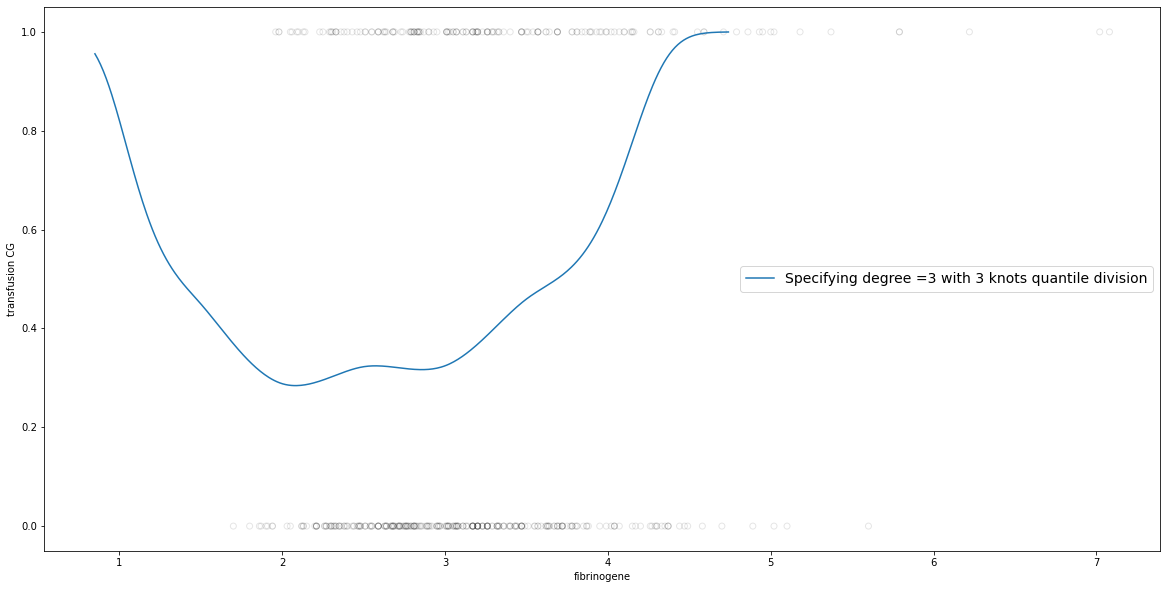

In [18]:
# Generating cubic spline with 3 knots
transformed_x = dmatrix("bs(train, knots=(1.5, 2, 2.5, 3, 3.5), degree=3, include_intercept=False)", {"train": x},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.Logit(y, transformed_x).fit()

# Generating cubic spline with 4 knots
#transformed_x2 = dmatrix("bs(train, knots=(2.776,3.852,4.928,6.004),degree =3, include_intercept=False)", {"train": x}, return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
#fit2 = sm.Logit(y, transformed_x2).fit()

# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(1.5, 2, 2.5, 3, 3.5), include_intercept=False)", {"valid": x}, return_type='dataframe'))
#pred2 = fit2.predict(dmatrix("bs(valid, knots=(2.776,3.852,4.928,6.004),degree =3, include_intercept=False)", {"valid": x}, return_type='dataframe'))

# Calculating RMSE values
rms1 = sqrt(mean_squared_error(y, pred1))
print(rms1)
#rms2 = sqrt(mean_squared_error(y, pred2))
#print(rms2)

# We will plot the graph 
xp = np.linspace(x.min(),x.max(),453)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(xp, knots=(1.5, 2, 2.5, 3, 3.5), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
#(2.67,3.07,3.62)pred2 = fit2.predict(dmatrix("bs(xp, knots=(2.776,3.852,4.928,6.004),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Plot the splines and error bands
plt.figure(figsize=(20,10))
plt.scatter(data["fibrinogene"], data["transfusion CG"], facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots quantile division')
#plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots function division')
plt.legend(prop={'size': 14})
plt.xlabel('fibrinogene')
plt.ylabel('transfusion CG')
plt.show()

We know that the behavior of polynomials that are fit to the data tends to be erratic near the boundaries. Such variability can be dangerous. These problems are resembled by splines, too. The polynomials fit beyond the boundary knots behave even more wildly than the corresponding global polynomials in that region. To smooth the polynomial beyond the boundary knots, we will use a special type of spline known as Natural Spline.

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. This constrains the cubic and quadratic parts there to 0, each reducing the degrees of freedom by 2. That’s 2 degrees of freedom at each of the two ends of the curve, reducing K+4 to K.


https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.cc

In [19]:
# Divide by function
# Dividing the data into 4 bins
df_cut, bins = pd.cut(x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(0.846, 1.822]    144
(1.822, 2.795]    236
(2.795, 3.768]     51
(3.768, 4.74]      14
Name: Fibri2, dtype: int64

Optimization terminated successfully.
         Current function value: 0.628849
         Iterations 5
0.4679763687577805


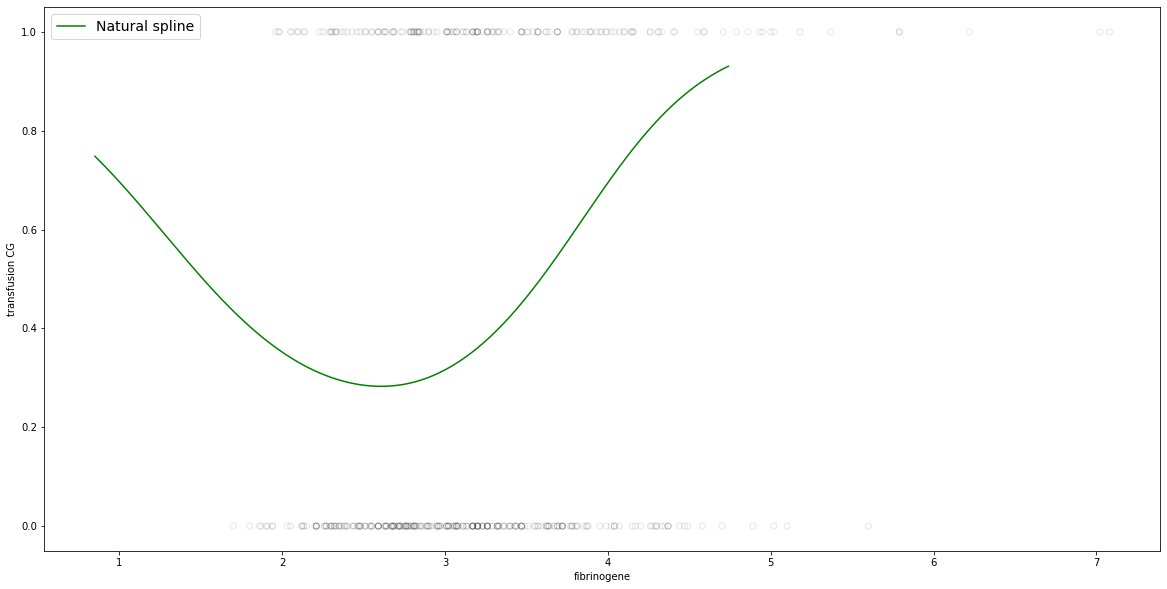

In [20]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train, df = 3)", {"train": x}, return_type='dataframe')
fit3 = sm.Logit(y, transformed_x3 ).fit()

# Prediction 
pred3 = fit3.predict(dmatrix("cr(train, df = 3)", {"train": x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(y, pred3))
print(rms)

# We will plot the graph for 300 observations 
xp = np.linspace(x.min(),x.max(),453)
pred3 = fit3.predict(dmatrix("cr(xp, df = 3)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.figure(figsize=(20,10))
plt.scatter(data["fibrinogene"], data["transfusion CG"], facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3, color='g', label='Natural spline')
plt.legend(prop={'size': 14})
plt.xlabel('fibrinogene')
plt.ylabel('transfusion CG')
plt.show()

source 2 en R : https://freakonometrics.hypotheses.org/tag/xgboost

In [21]:
transformed_x3 

,Intercept,"cr(train, df=3)[0]","cr(train, df=3)[1]","cr(train, df=3)[2]"
0,1.0,-0.078177,1.054795,0.023383
1,1.0,0.592394,0.431782,-0.024176
2,1.0,-0.141639,1.087824,0.053816
3,1.0,0.207490,0.818580,-0.026070
4,1.0,-0.271575,0.975827,0.295747
...,...,...,...,...
469,1.0,0.236330,0.791131,-0.027462
470,1.0,0.027584,0.978212,-0.005796
471,1.0,0.366245,0.663614,-0.029860
473,1.0,0.068657,0.944078,-0.012735


In [22]:
x

0      2.27
1      1.30
2      2.43
3      1.78
4      3.23
       ... 
469    1.74
470    2.06
471    1.57
473    1.99
474    3.03
Name: Fibri2, Length: 445, dtype: float64